In [4]:
%load_ext autoreload
%autoreload 2

import os
import time

import sys
sys.path.append(os.environ['GORDON_REPO_DIR'] + '/pipeline_scripts')

import utilities2014
reload(utilities2014)
from utilities2014 import *

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filters.rank import gradient

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
section_ind = 2
dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=section_ind)
dm._load_image()

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1

texture_map = dm.load_pipeline_result('textureMap', 'npy')
Gmax = dm.load_pipeline_result('Gmax', 'npy')
Gmax_viz = plt.cm.jet(Gmax/np.nanmax(Gmax))

thetas = np.linspace(-np.pi/4, np.pi/4, 9)
n_theta = len(thetas)
Rs = [np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) for theta in thetas]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/matplotlib/colors.py:584: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


In [6]:
lm_ind = 3

lm = np.load('/home/yuncong/csd395/sample_landmark_%d.npy'%lm_ind)

# lm_int_texture = lm[:, 2:2+n_texton]
# lm_ext_texture = lm[:, 2+n_texton:-2]
# lm_vector = lm[:, -2:]
lm_pts = lm[:, [1,0]]
lm_pts_centered = lm_pts - lm_pts.mean(axis=0)

template_points_rotated_versions = []
for R in Rs:
    lm_pts_rotated = np.dot(R, lm_pts_centered.T).astype(np.int).T
    lm_pts_rotated_shifted = lm_pts_rotated - lm_pts_rotated.min(axis=0)
    template_points_rotated_versions.append(lm_pts_rotated_shifted)

template_shape_rotated_versions = [pts.max(axis=0) + [1,1] for pts in template_points_rotated_versions]

In [7]:
locs = np.load('/home/yuncong/csd395/top3LocsLm%dSect%d.npy'%(lm_ind, section_ind))
shifted_ymean_best, shifted_xmean_best, v, orientation = locs[0]
template_points = template_points_rotated_versions[int(orientation)]
shifted_ys_best = (shifted_ymean_best - template_points[:,0].mean(axis=0) + template_points[:,0]).astype(np.int)
shifted_xs_best = (shifted_xmean_best - template_points[:,1].mean(axis=0) + template_points[:,1]).astype(np.int)

In [8]:
print shifted_xs_best.min(), shifted_xs_best.max(), shifted_ys_best.min(), shifted_ys_best.max()

2460 3227 1848 2208


In [9]:
x1 = 2400
x2 = 3300
y1 = 1800
y2 = 2250

In [10]:
def draw_zero_crossing(u, bg=None):
    s = np.sign(u)
    zero_crossings = np.where(np.c_[np.diff(s, axis=1), np.zeros(h,)] + 
                              np.r_[np.diff(s, axis=0), np.zeros((1,w))])
    
    overlay = np.zeros((h,w), np.bool)
    overlay[zero_crossings] = 1
    overlay = binary_dilation(overlay, disk(5))
    
    if bg is None:
        return overlay
    else:
        res = bg.copy()
        res[overlay] = [0,1,0]
        return res

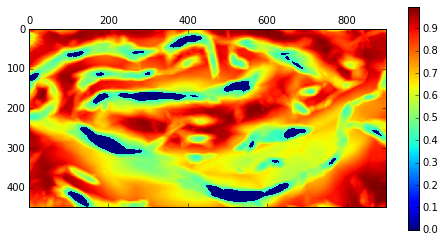

In [11]:
im = dm.image_rgb[y1:y2][:, x1:x2].copy()

h,w = im.shape[:2]

ys, xs = np.mgrid[:h,:w]
ys = ys.astype(np.float)
xs = xs.astype(np.float)


g = 1./(1 + Gmax[y1:y2][:, x1:x2]**2)
g[g<.4] = 0.0001
dgdy, dgdx = np.gradient(g)

gviz = plt.cm.jet(g)
plt.matshow(g);
plt.colorbar();

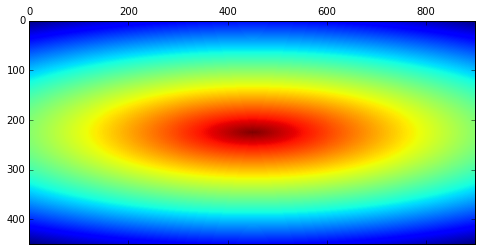

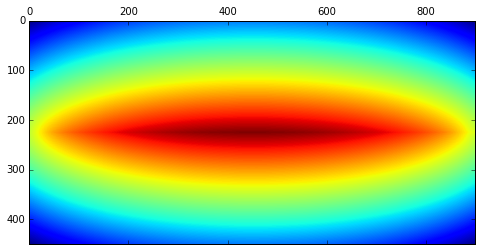

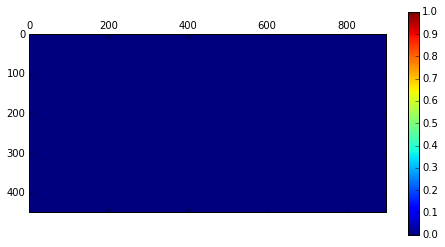

In [29]:
u0 = -(np.sqrt(((xs - w/2)/1.8)**2 + ((ys - h/2)/0.5)**2) - 250)
u0 = reinitialize(u0, n_iter=1000)

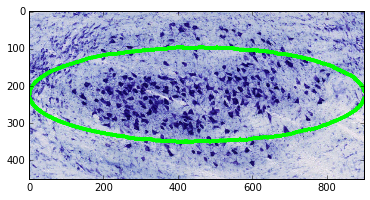

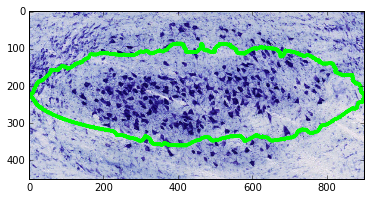

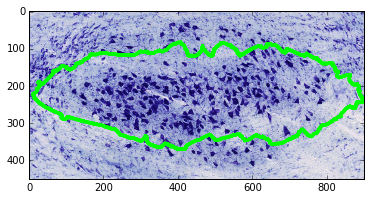

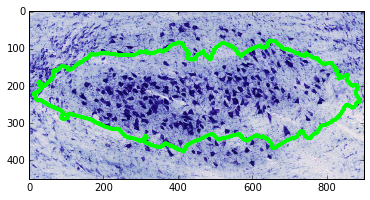

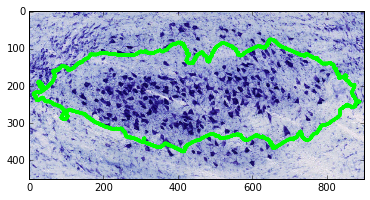

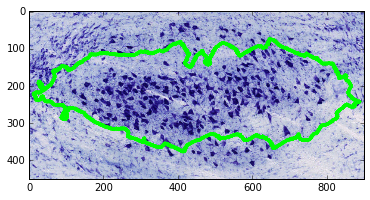

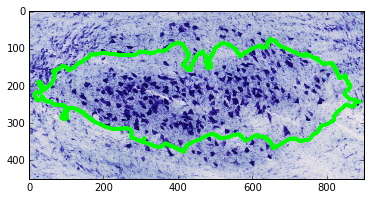

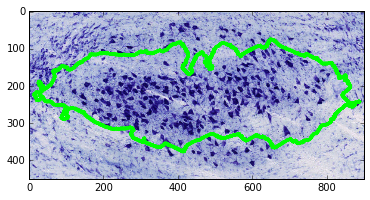

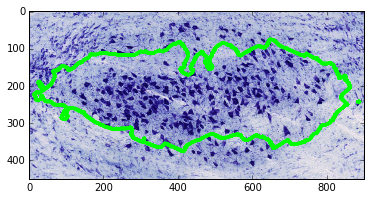

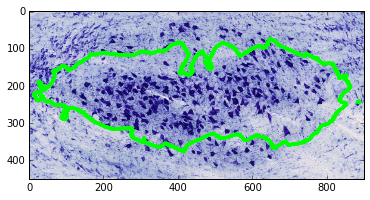

In [22]:
# Use Morphological Snakes https://github.com/pmneila/morphsnakes

sys.path.append(os.environ['GORDON_REPO_DIR'] + '/pipeline_scripts/preprocess/morphsnakes')
from morphsnakes import MorphGAC

mgac = MorphGAC(g, smoothing=1, threshold=0, balloon=0)
mgac.levelset = u0.copy()

for i in range(100):
    mgac.step()
    if i % 10 == 0:
#         viz = draw_zero_crossing(mgac.levelset, bg=gviz[:,:,:3])
        viz = draw_zero_crossing(mgac.levelset, bg=im)
        plt.imshow(viz);
        plt.show();

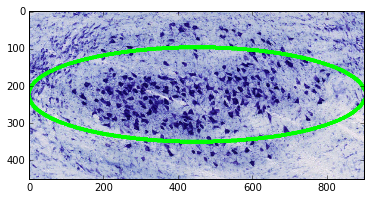

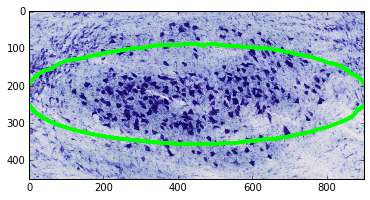

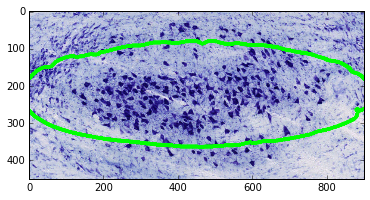

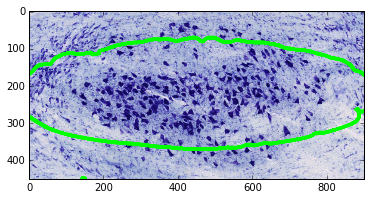

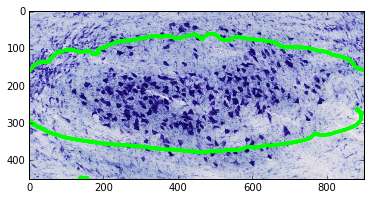

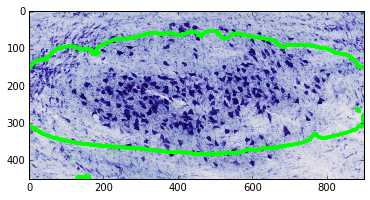

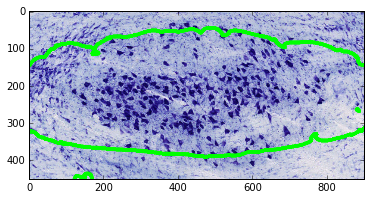

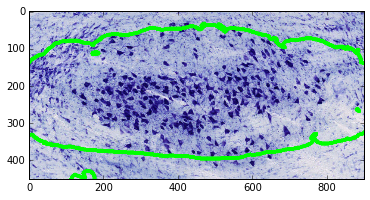

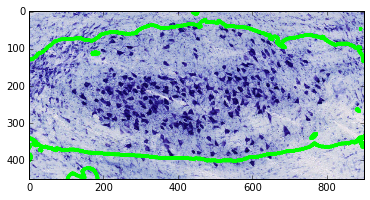

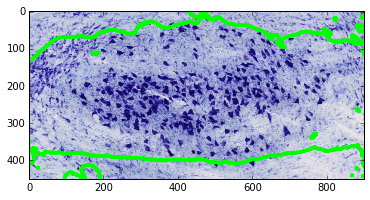

In [40]:
# Use canonical Geodesic Active Contours

u = u0.copy()

for i in range(100):
    u = step(u, g, cc = 1.)
    u = reinitialize(u, n_iter=1)
    if i%10 == 0:
        viz = draw_zero_crossing(u, bg=im)
        plt.imshow(viz);
#         plt.matshow(u);
#         plt.colorbar();
        plt.show();

In [14]:
def step(u, g, cc = 1., eps1 = 1e-10):
    
    dudy, dudx = np.gradient(u)
    du_norm = np.sqrt(dudy**2 + dudx**2)
    du_unit_y = dudy / (du_norm + eps1)
    du_unit_x = dudx / (du_norm + eps1)
    dudydy, _ = np.gradient(du_unit_y)
    _, dudxdx = np.gradient(du_unit_x)
    k = dudydy + dudxdx
    
    dudt = (cc+k)*g*du_norm + dgdy*dudy + dgdx*dudx
    u += dudt
    
    assert not np.isnan(u).any() and not np.isinf(u).any()
    
    return u

In [31]:
def reinitialize(u, n_iter=10):
    
    s = u/np.sqrt(u**2+1)

    u2 = u.copy()
    
    for j in range(n_iter):
        dx = np.diff(u2, axis=1)
        dy = np.diff(u2, axis=0)
    #     b = np.c_[dx, -u2[:,-1]]
        b = np.c_[dx, np.zeros((h,1))]
        a = np.c_[np.zeros((h,1)), dx]
    #     d = np.r_[dy, -u2[-1,:][None,:]]
        d = np.r_[dy, np.zeros((1,w))]
        c = np.r_[np.zeros((1,w)), dy]

        du_norm = np.zeros_like(u)
        du_norm[u>0] = np.sqrt(np.maximum(np.maximum(0,a[u>0])**2, np.minimum(0,b[u>0])**2)+
                               np.maximum(np.maximum(0,c[u>0])**2, np.minimum(0,d[u>0])**2))

        du_norm[u<0] = np.sqrt(np.maximum(np.maximum(0,b[u<0])**2, np.minimum(0,a[u<0])**2)+
                           np.maximum(np.maximum(0,d[u<0])**2, np.minimum(0,c[u<0])**2))

#     dudy, dudx = np.gradient(u2)
#     du_norm = np.sqrt(np.maximum(np.maximum(dudy,0)**2, np.minimum(dudy,0)**2) + 
#                       np.maximum(np.maximum(dudx,0)**2, np.minimum(dudx,0)**2))

        u2 += 0.2*s*(1-du_norm)
    
    assert not np.isnan(u2).any() and not np.isinf(u2).any()
    
#     plt.matshow(u);
#     plt.show()

#     plt.matshow(u2);
#     plt.show()

#     plt.matshow(du_norm-1., vmin=0, vmax=1);
#     plt.colorbar();
#     plt.show()
    
    return u2